In [1]:
from SimPEG import *
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave_HM = skytem_HM_2015()
wave_LM = skytem_LM_2015()
time_HM = wave_HM.time_gate_center
time_LM = wave_LM.time_gate_center

hz = get_vertical_discretization_time(
    np.unique(np.r_[time_HM, time_LM]), facter_tmax=0.5, factor_tmin=10., n_layer=20
)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

time_input_currents_HM = wave_HM.current_times[-7:]
input_currents_HM = wave_HM.currents[-7:]
time_input_currents_LM = wave_LM.current_times[-13:]
input_currents_LM = wave_LM.currents[-13:]

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time_HM,
    time_input_currents=time_input_currents_HM,
    input_currents=input_currents_HM,
    n_pulse = 2,
    base_frequency = 25.,
    use_lowpass_filter=True,
    high_cut_frequency=210*1e3,
    moment_type='dual',
    time_dual_moment = time_HM,    
    time_input_currents_dual_moment=time_input_currents_LM,
    input_currents_dual_moment=input_currents_LM,
    base_frequency_dual_moment=210,    
)
sig_half = 1./30.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [3]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-100>LocSigZ) & (-120<LocSigZ)
sig[blk_ind] = 1./5.
blk_ind = (-120>LocSigZ) & (-300<LocSigZ)
sig[blk_ind] = 1./30.
blk_ind = -300>LocSigZ
sig[blk_ind] = 1.
m_true = np.log(sig)

In [4]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

(0.5, 100)

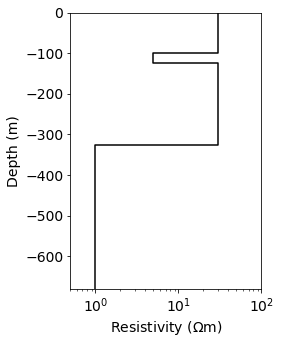

In [5]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
ax.set_xlabel("Resistivity ($\Omega$m)")
plt.tight_layout()
fig.savefig('resistivity', dpi=200)
ax.set_xlim(0.5, 100)

In [6]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)
# J = prob.getJ_sigma(m_true)

CPU times: user 172 ms, sys: 20.4 ms, total: 193 ms
Wall time: 214 ms


In [7]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.1
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

In [8]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


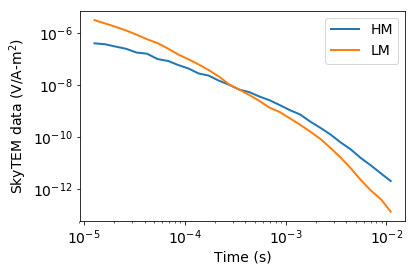

In [9]:
fig, axes = subplots(1,1, figsize = (6,4))
axes.plot(TDsurvey.time, -TDsurvey.dobs[:TDsurvey.n_time], '-', lw=2)
axes.plot(TDsurvey.time_dual_moment, -TDsurvey.dobs[TDsurvey.n_time:], '-', lw=2)
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("HM", "LM"))
plt.xlabel("Time (s)")
plt.ylabel("SkyTEM data (V/A-m$^2$)")
plt.tight_layout()
fig.savefig('skytem_data', dpi=200)

In [16]:
prob.depth_of_investigation(std, thres_hold=0.8)

(326.95993174205154,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False]))

In [11]:
e = np.ones((3,3))

In [12]:
np.power(e, 2)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
reg = Regularization.Sparse(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, betaSearch=False,
    chifact_start = 1.
)
opt = Optimization.ProjectedGNCG(maxIter = 40)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
save = Directives.SaveOutputEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, save])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [ ]:
%%time
mopt = inv.run(m0)

In [13]:
# save.plot_misfit_curves()
# save.plot_tikhonov_curves()

In [15]:
# figsize(5,5)
# plt.plot(save.phi_m, save.phi_d)
# plt.plot(save.phi_m[save.i_target], save.phi_d[save.i_target], 'k*', ms=10)

In [16]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :       26
  ProjectedGNCG.doEndIteration            :       26
  ProjectedGNCG.doStartIteration          :       26
  ProjectedGNCG.projection                :      108
  ProjectedGNCG.scaleSearchDirection      :       26

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 5.37e-04, 6.87e-02,  128x
  EM1D.Jvec_approx                        : 8.35e-04, 1.07e-01,  128x
  ProjectedGNCG.findSearchDirection       : 3.89e-02, 1.01e+00,   26x
  ProjectedGNCG.minimize                  : 1.94e+01, 1.94e+01,    1x
  ProjectedGNCG.modifySearchDirection     : 2.34e-01, 6.08e+00,   26x


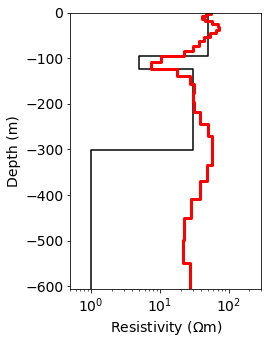

In [17]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)
Utils1D.plotLayer(1./(expmap*invProb.l2model), mesh1D, showlayers=False, **{'color':'r', 'lw':3})
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_xlim(0.5, 300)
plt.tight_layout()
fig.savefig('resistivity_l2', dpi=200)


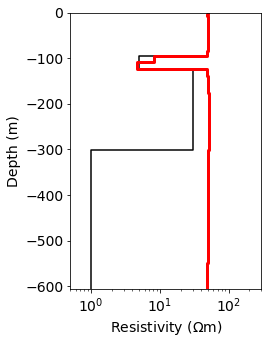

In [18]:
fig, ax = subplots(1,1, figsize=(4, 5))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=False, ax=ax)

Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=False, **{'color':'r', 'lw':3})
# Utils1D.plotLayer(1./(expmap*invProb.l2model), mesh1D, showlayers=False, **{'color':'b', 'lw':3})
ax.set_xlabel("Resistivity ($\Omega$m)")
ax.set_xlim(0.5, 300)
plt.tight_layout()
fig.savefig('resistivity_l0', dpi=200)


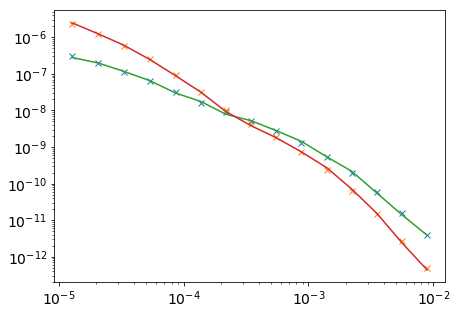

In [19]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred[:TDsurvey.n_time], 'x')
axes.plot(TDsurvey.time_dual_moment, -invProb.dpred[TDsurvey.n_time:], 'x')
axes.plot(TDsurvey.time, -TDsurvey.dobs[:TDsurvey.n_time])
axes.plot(TDsurvey.time_dual_moment, -TDsurvey.dobs[TDsurvey.n_time:])

axes.set_xscale('log');
axes.set_yscale('log');